In [1]:
import os
import time

import numpy as np
import pandas as pd
import soundfile as sf
import pyroomacoustics as pra
import matplotlib.pyplot as plt

from scipy.signal import stft
from pathlib import Path 

In [2]:
from alphaMusic.utils.geo_utils import cart2sph, sph2cart

In [3]:
data_dir = '../data/toydata/'

seed = 666

RT60 = 0.256
SNR = 10

alpha = 3 # alpha > 3 => estimated, alpha in (0, 2] => fixed, alpha = 2 => aMUSIC = MUSIC
n_srcs = 3
n_mics = 5

nfft = 1024
minF = 1000
maxF = 4000

azimuth_grid_spacing = 1

In [4]:
# set up folders
data_dir = Path(data_dir)

# set up random seed
np.random.seed(seed)

In [5]:
# GET DATA
file_paths = list(data_dir.glob("*.flac"))[:n_srcs]

# allocate memory
id_biggest_file = np.argmax([os.path.getsize(file) for file in file_paths])
tmp_wav, fs = sf.read(file_paths[id_biggest_file])
max_length = len(tmp_wav)
speech_dry_NT = np.zeros([n_srcs, max_length], dtype=np.float32)

# get anechoic speech
obs_MT = np.zeros([n_mics, max_length], dtype=np.float32)
Name_file = ''
for id_fp, file_path in enumerate(file_paths):
    name_file = file_path.name.split('.')[0]
    if id_fp == 0:
        Name_file += name_file
    else:
        Name_file += '_{}'.format(name_file)
    tmp_wav, fs = sf.read(file_path)
    print('source {}:\t{}\t[fs : {} Hz\tduration : {} sec]'.format(id_fp + 1, name_file, fs, tmp_wav.shape[0]/fs))
    tmp_wav /= np.std(tmp_wav)
    speech_dry_NT[id_fp, :len(tmp_wav)] = tmp_wav

print('speech dry shape', speech_dry_NT.shape)

# noise file
noise_name = 'office_noise.wav'
noise, fs = sf.read(data_dir / Path(noise_name))
print('noise\t{}\t[fs: {}\tduration {}\tn mics {}]'.format(noise_name, fs, noise.shape[0]/fs, noise.shape[1]))
noise_MT = noise.T
print('noise shape', noise_MT.shape)



source 1:	5536-43358-0018	[fs : 16000 Hz	duration : 12.065 sec]
source 2:	6241-66616-0012	[fs : 16000 Hz	duration : 10.63 sec]
source 3:	84-121123-0024	[fs : 16000 Hz	duration : 10.38 sec]
speech dry shape (3, 193040)
noise	office_noise.wav	[fs: 16000	duration 9.680875	n mics 7]
noise shape (7, 154894)


In [31]:
ref_doa = np.random.randint(0,180) # in degree
# the other 2 sources are +- 30 degree
AOA_ref = np.array([ref_doa, ref_doa+60, ref_doa-25])
AOA_ref = np.mod(AOA_ref, 360)

distances = 3*[1.5] # metres
elevations = 3*[0]

/tmp/ipykernel_570756/261773196.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


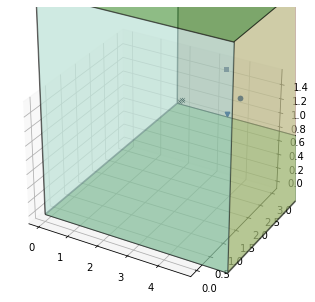

In [32]:
ref_source_doa = np.random.randint(0,360)


# simulate reverberation
room_dim = [6.0, 5.0, 3.0]  # meters
if RT60 < 0.2:
    e_absorption = 0.99
    max_order = 0
else:
    e_absorption, max_order = pra.inverse_sabine(RT60, room_dim)

room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

 # add spherical array
mic_center = np.c_[[3.2, 1.5, 1.5]]
mic_radius = 0.06
mic_pos = pra.circular_2D_array(mic_center[:2, 0], n_mics, 0, mic_radius)
mic_pos = np.concatenate((mic_pos, np.ones((1, n_mics)) * mic_center[2, 0]), axis=0)
room.add_microphone_array(mic_pos)

# add sources

true_positions = {}
for n in range(n_srcs):
    
    az = AOA_ref[n]
    el = elevations[n]
    dst = distances[n]
    
    src_sph = np.array([[dst, az, el]]).T
    src_cart_rel = sph2cart(src_sph)
    src_cart_abs = src_cart_rel + mic_center

    
    room.add_source(src_cart_abs, signal=speech_dry_NT[n])

    true_positions['abs'] = src_cart_abs
    true_positions['sph'] = src_sph


room.plot()
plt.tight_layout()
plt.show()

In [33]:
room.simulate()

In [34]:
mixtures = room.mic_array.signals
print('Input mixture shape:', mixtures.shape)

# normalize std of the mixtures
std_mixtures = np.std(mixtures, axis=1, keepdims=True)
mixtures = mixtures / std_mixtures

# add noise
L = min(mixtures.shape[1], noise_MT.shape[1])
noise = noise_MT[:n_mics,:L]
mixtures = mixtures[:,:L]
print('Input noise shape', noise.shape)

# scale according to the SNR
noise = noise / np.std(noise, axis=1, keepdims=True)
sigma_n = np.sqrt(10 ** (- SNR / 10))
noise = sigma_n * noise

mixtures = mixtures + noise
print(mixtures.shape)

# to STFT
freqs, times, obs_FTM = stft(mixtures[:, fs:2*fs], fs=fs, nfft=nfft, nperseg=nfft, noverlap=0.5)
print(obs_FTM.shape)

Input mixture shape: (5, 202710)
Input noise shape (5, 154894)
(5, 154894)
(5, 513, 17)


True AOAs [ 23  83 358]
MUSIC	[88.  7. 15.]
aMUSIC	[86.  6. 13.]
NormMUSIC	[180.  88.   6.]
aNormMUSIC	[181.  86.  11.]


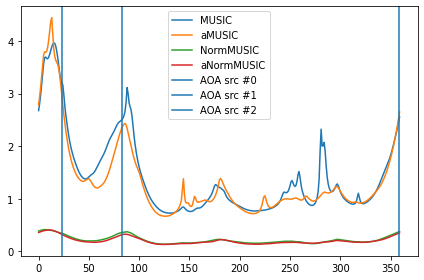

In [36]:
from alphaMusic.alphaMUSIC import aMUSIC
from pyroomacoustics.doa import MUSIC, NormMUSIC, SRP

doa_grid = np.arange(360,step=1)

kwargs = {
     'L': mic_pos
    ,'fs': fs
    ,'nfft': nfft
    ,'azimuth': np.deg2rad(doa_grid)
    ,'num_src': n_srcs
}
            
algorithms = {
    'MUSIC':         MUSIC(**kwargs),
    'aMUSIC' :      aMUSIC(**kwargs,alpha=alpha,frequency_normalization=False),
    'NormMUSIC': NormMUSIC(**kwargs),
    'aNormMUSIC' :  aMUSIC(**kwargs,alpha=alpha,frequency_normalization=True),
}


print('True AOAs', AOA_ref)

for algo_name, algo in algorithms.items():

    start = time.time()
    algo.locate_sources(obs_FTM, num_src=n_srcs, freq_range=[minF, maxF])
    time_elapsed = time.time() - start

    doas_pred = np.rad2deg(algo.azimuth_recon)

    plt.plot(doa_grid, np.mean(algo.Pssl, axis=1), label=algo_name)

    print(f'{algo_name}\t{doas_pred}')

for d, doa in enumerate(AOA_ref):
    plt.axvline(x=doa, label=f'AOA src #{d}')

plt.legend()
plt.tight_layout()
plt.show()
